# **Exploratory Data Analysis of Illicit v Licit Addresses**

--------------

The purpose of this notebook is to find patterns between illicit and licit wallet addresses. The dataset contains 823k addresses of which  558k (68%) are unknown status, 251k (30%) have engaged in licit activity and the remaining 14k (2%) have engaged in illicit activity. This analysis identifies patterns at an actor level. This analysis identifies patterns at an address level for licit and illicit transactions only.

The Elliptic++ dataset is an enhancement of the Elliptic1 dataset. This dataset includes transaction information that can be validated using blockchain wallet search websites. See here:

Elliptic1 Paper and Dataset:
https://arxiv.org/pdf/1908.02591,
https://www.kaggle.com/datasets/ellipticco/elliptic-data-set/data

Elliptic++ Paper and Dataset:
https://arxiv.org/pdf/2306.06108,
https://github.com/git-disl/EllipticPlusPlus

--------------

In [ ]:
# Data cleaning and manipulation
import pandas as pd
import numpy as np
from pandas_gbq import to_gbq

# Visualisation Libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Set up display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Suppress FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


-------------------
### Read in Datasets used for Validation

The required dataset is wallet_combined_clean which is used for wallet level analysis with class labels. This dataset has duplicates removed so there is 1 row per wallet, with summarised transaction information across all timesteps.

-------------------

In [ ]:
# Read in combined wallet features table from BigQuery
%%bigquery df_wallet_combined_clean
select * from `sixth-legend-440110-g7.actor_data.wallets_combined_clean`;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
# Create a copy of the df
data = df_wallet_combined_clean.copy()

In [ ]:
print(data.shape)
data.head(1)

(822942, 58)


,address,class,class_label,num_txs_as_sender,num_txs_as receiver,first_block_appeared_in,last_block_appeared_in,lifetime_in_blocks,total_txs,first_sent_block,first_received_block,num_timesteps_appeared_in,btc_transacted_total,btc_transacted_min,btc_transacted_max,btc_transacted_mean,btc_transacted_median,btc_sent_total,btc_sent_min,btc_sent_max,btc_sent_mean,btc_sent_median,btc_received_total,btc_received_min,btc_received_max,btc_received_mean,btc_received_median,fees_total,fees_min,fees_max,fees_mean,fees_median,fees_as_share_total,fees_as_share_min,fees_as_share_max,fees_as_share_mean,fees_as_share_median,blocks_btwn_txs_total,blocks_btwn_txs_min,blocks_btwn_txs_max,blocks_btwn_txs_mean,blocks_btwn_txs_median,blocks_btwn_input_txs_total,blocks_btwn_input_txs_min,blocks_btwn_input_txs_max,blocks_btwn_input_txs_mean,blocks_btwn_input_txs_median,blocks_btwn_output_txs_total,blocks_btwn_output_txs_min,blocks_btwn_output_txs_max,blocks_btwn_output_txs_mean,blocks_btwn_output_txs_median,num_addr_transacted_multiple,transacted_w_address_total,transacted_w_address_min,transacted_w_address_max,transacted_w_address_mean,transacted_w_address_median
0,12m825yQ4vhS2zrd7ynZT4bBqKSMZYxuku,3,Unknown,1.0000,0.0000,457729.0000,457729.0000,0.0000,1.0000,457729.0000,0.0000,1.0000,0.0427,0.0427,0.0427,0.0427,0.0427,0.0427,0.0427,0.0427,0.0427,0.0427,0.0000,0.0000,0.0000,0.0000,0.0000,0.0028,0.0028,0.0028,0.0028,0.0028,0.0003,0.0003,0.0003,0.0003,0.0003,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,1.0000,1.0000,1.0000,1.0000


-------------------
### Descriptive Statistics

The purpose of the below section is to get a high-level understanding of the data in raw form.

-------------------

In [ ]:
# Remove unnecessary colums
cols_to_drop = ['first_block_appeared_in', 'last_block_appeared_in', 'first_sent_block', 'first_received_block']
data.drop(columns = cols_to_drop, inplace = True)
print(data.shape)

(822942, 54)


In [ ]:
# Group by 'class' and 'class_label', and count the number of addresses
grouped_data = data.groupby(['class', 'class_label']).agg(
    count=('address', 'count')  # Count the number of addresses
).reset_index()

# Calculate the total number of addresses
total_addresses = grouped_data['count'].sum()

# Calculate the percentage of addresses for each group
grouped_data['percentage'] = (grouped_data['count'] / total_addresses) * 100

grouped_data


,class,class_label,count,percentage
0,1,Illicit,14266,1.7335
1,2,Licit,251088,30.5110
2,3,Unknown,557588,67.7554


In [ ]:
# remove Unknown classes
data = data[~data['class_label'].isin(['Unknown'])]
data['class_label'].value_counts()

,count
class_label,
Licit,251088
Illicit,14266


--------------------------
Get Percentiles of Features

--------------------------


In [ ]:
# Describe dataset with set percentiles
custom_perc = [0, 0.25, 0.5, 0.75,0.9, 0.95, 0.99, 0.99995]
data.describe(percentiles = custom_perc)

,class,num_txs_as_sender,num_txs_as receiver,lifetime_in_blocks,total_txs,num_timesteps_appeared_in,btc_transacted_total,btc_transacted_min,btc_transacted_max,btc_transacted_mean,btc_transacted_median,btc_sent_total,btc_sent_min,btc_sent_max,btc_sent_mean,btc_sent_median,btc_received_total,btc_received_min,btc_received_max,btc_received_mean,btc_received_median,fees_total,fees_min,fees_max,fees_mean,fees_median,fees_as_share_total,fees_as_share_min,fees_as_share_max,fees_as_share_mean,fees_as_share_median,blocks_btwn_txs_total,blocks_btwn_txs_min,blocks_btwn_txs_max,blocks_btwn_txs_mean,blocks_btwn_txs_median,blocks_btwn_input_txs_total,blocks_btwn_input_txs_min,blocks_btwn_input_txs_max,blocks_btwn_input_txs_mean,blocks_btwn_input_txs_median,blocks_btwn_output_txs_total,blocks_btwn_output_txs_min,blocks_btwn_output_txs_max,blocks_btwn_output_txs_mean,blocks_btwn_output_txs_median,num_addr_transacted_multiple,transacted_w_address_total,transacted_w_address_min,transacted_w_address_max,transacted_w_address_mean,transacted_w_address_median
count,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000,265354.0000
mean,1.9462,0.5572,0.8277,1360.7542,1.3848,1.0982,2.3103,1.0354,1.2337,1.0751,1.0632,1.1555,0.3449,0.7752,0.5048,0.4897,1.1548,0.4083,0.8132,0.5704,0.5625,0.0140,0.0102,0.0128,0.0115,0.0114,0.0003,0.0002,0.0003,0.0002,0.0002,1360.7555,505.0117,987.0898,705.9404,671.5580,245.1352,137.2342,200.3482,159.9112,154.1513,1159.8012,513.7188,832.7233,654.0386,637.5168,0.1191,10.4185,1.0304,1.0782,1.0404,1.0341
std,0.2255,4.5393,3.1262,7530.3605,6.6906,0.6014,107.5236,23.4238,29.6283,23.7144,23.6181,62.3820,15.9866,24.0076,16.3980,16.2353,50.2846,15.9471,20.9480,16.3747,16.4641,0.0337,0.0251,0.0275,0.0256,0.0256,0.0096,0.0015,0.0018,0.0015,0.0015,7530.3671,3429.2500,5037.2512,3846.0859,3815.7253,3240.9927,2050.8850,2527.6981,2148.1074,2134.5586,7039.6474,3393.1268,4629.0627,3784.0681,3778.5368,14.7657,103.2965,0.2705,0.8820,0.2862,0.2786
min,1.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
0%,1.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
25%,2.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0008,0.0007,0.0008,0.0007,0.0007,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0006,0.0004,0.0005,0.0005,0.0005,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
50%,2.0000,0.0000,1.0000,0.0000,1.0000,1.0000,0.0115,0.0100,0.0100,0.0100,0.0100,0.0000,0.0000,0.0000,0.0000,0.0000,0.0004,0.0001,0.0004,0.0003,0.0003,0.0019,0.0017,0.0019,0.0019,0.0019,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,1.0000,1.0000,1.0000,1.0000
75%,2.

-------------------

### Feature Enhancement

The purpose of this section is to build additional features which will assist to find differences in patterns between illicit and licit actor behaviour. The feature enhancement includes the addition of features and binning existing features.

- ratio_sent_received_txn_counts (all txn)
- ratio_sent_received_txn_value (all txn)
- Binned fields

-------------------

Build additional features:
1. Ratio of Sent v Received Txn Counts (Count of Txn Sent v Txn Received)
2. Ratio of Sent v Received Value Retained (Txn Value Sent v Txn Value Received)


In [ ]:
# Ratio of Debit (Sender) v Credit (Receiver) Txn Counts
data['prop_sent_total_txn_counts'] = round(data['num_txs_as_sender'] / data['total_txs'],4)

# Ratio of Debit (Sender) v Credit (Receiver) Txn Value
data['prop_sent_total_txn_value'] = round(data['btc_sent_total'] / data['btc_transacted_total'],4)

data.head()

,address,class,class_label,num_txs_as_sender,num_txs_as receiver,lifetime_in_blocks,total_txs,num_timesteps_appeared_in,btc_transacted_total,btc_transacted_min,btc_transacted_max,btc_transacted_mean,btc_transacted_median,btc_sent_total,btc_sent_min,btc_sent_max,btc_sent_mean,btc_sent_median,btc_received_total,btc_received_min,btc_received_max,btc_received_mean,btc_received_median,fees_total,fees_min,fees_max,fees_mean,fees_median,fees_as_share_total,fees_as_share_min,fees_as_share_max,fees_as_share_mean,fees_as_share_median,blocks_btwn_txs_total,blocks_btwn_txs_min,blocks_btwn_txs_max,blocks_btwn_txs_mean,blocks_btwn_txs_median,blocks_btwn_input_txs_total,blocks_btwn_input_txs_min,blocks_btwn_input_txs_max,blocks_btwn_input_txs_mean,blocks_btwn_input_txs_median,blocks_btwn_output_txs_total,blocks_btwn_output_txs_min,blocks_btwn_output_txs_max,blocks_btwn_output_txs_mean,blocks_btwn_output_txs_median,num_addr_transacted_multiple,transacted_w_address_total,transacted_w_address_min,transacted_w_address_max,transacted_w_address_mean,transacted_w_address_median,prop_sent_total_txn_counts,prop_sent_total_txn_value
2,1WMbzTvEfKfCiXNPLQJzSWS3ywqRMNgd5,2,Licit,1.0000,0.0000,0.0000,1.0000,1.0000,0.0154,0.0154,0.0154,0.0154,0.0154,0.0154,0.0154,0.0154,0.0154,0.0154,0.0000,0.0000,0.0000,0.0000,0.0000,0.0057,0.0057,0.0057,0.0057,0.0057,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1JkzpUExX89VhZR6rbvpTUgtfKXxTY6QRj,2,Licit,1.0000,0.0000,0.0000,1.0000,1.0000,0.0067,0.0067,0.0067,0.0067,0.0067,0.0067,0.0067,0.0067,0.0067,0.0067,0.0000,0.0000,0.0000,0.0000,0.0000,0.0068,0.0068,0.0068,0.0068,0.0068,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,17cMAtqFEpX3p8PKjWj3ryWdBaZPySLFGM,2,Licit,1.0000,0.0000,0.0000,1.0000,1.0000,0.0003,0.0003,0.0003,0.0003,0.0003,0.0003,0.0003,0.0003,0.0003,0.0003,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0001,0.0001,0.0001,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1FCerfzEAbzE958LmSHQ7jg2uWazSdEJ8,2,Licit,1.0000,0.0000,0.0000,1.0000,1.0000,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0000,0.0000,0.0000,0.0000,0.0000,0.0121,0.0121,0.0121,0.0121,0.0121,0.0004,0.0004,0.0004,0.0004,0.0004,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
12,1Mts9UZEQKgMLZzwHsMdxYv8dsqPGtgXKw,2,Licit,1.0000,0.0000,0.0000,1.0000,1.0000,4.5684,4.5684,4.5684,4.5684,4.5684,4.5684,4.5684,4.5684,4.5684,4.5684,0.0000,0.0000,0.0000,0.0000,0.0000,0.0268,0.0268,0.0268,0.0268,0.0268,0.0004,0.0004,0.0004,0.0004,0.0004,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,10.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [ ]:
data.tail()

,address,class,class_label,num_txs_as_sender,num_txs_as receiver,lifetime_in_blocks,total_txs,num_timesteps_appeared_in,btc_transacted_total,btc_transacted_min,btc_transacted_max,btc_transacted_mean,btc_transacted_median,btc_sent_total,btc_sent_min,btc_sent_max,btc_sent_mean,btc_sent_median,btc_received_total,btc_received_min,btc_received_max,btc_received_mean,btc_received_median,fees_total,fees_min,fees_max,fees_mean,fees_median,fees_as_share_total,fees_as_share_min,fees_as_share_max,fees_as_share_mean,fees_as_share_median,blocks_btwn_txs_total,blocks_btwn_txs_min,blocks_btwn_txs_max,blocks_btwn_txs_mean,blocks_btwn_txs_median,blocks_btwn_input_txs_total,blocks_btwn_input_txs_min,blocks_btwn_input_txs_max,blocks_btwn_input_txs_mean,blocks_btwn_input_txs_median,blocks_btwn_output_txs_total,blocks_btwn_output_txs_min,blocks_btwn_output_txs_max,blocks_btwn_output_txs_mean,blocks_btwn_output_txs_median,num_addr_transacted_multiple,transacted_w_address_total,transacted_w_address_min,transacted_w_address_max,transacted_w_address_mean,transacted_w_address_median,prop_sent_total_txn_counts,prop_sent_total_txn_value
822924,12fbWXihB4vS5VYuNaKbQWYNLVUJnkkJ46,2,Licit,0.0000,2.0000,28217.0000,2.0000,2.0000,0.1687,0.0244,0.1442,0.0843,0.0843,0.0000,0.0000,0.0000,0.0000,0.0000,0.1687,0.0244,0.1442,0.0843,0.0843,0.0004,0.0002,0.0002,0.0002,0.0002,0.0000,0.0000,0.0000,0.0000,0.0000,28217.0000,28217.0000,28217.0000,28217.0000,28217.0000,0.0000,0.0000,0.0000,0.0000,0.0000,28217.0000,28217.0000,28217.0000,28217.0000,28217.0000,0.0000,2.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000
822929,1GD4hFB8Bvme8D4dbrMqjTxG9dqrNN52Hs,2,Licit,0.0000,2.0000,12091.0000,2.0000,2.0000,5.2727,1.3517,3.9210,2.6363,2.6363,0.0000,0.0000,0.0000,0.0000,0.0000,5.2727,1.3517,3.9210,2.6363,2.6363,0.0021,0.0007,0.0014,0.0010,0.0010,0.0003,0.0000,0.0003,0.0002,0.0002,12091.0000,12091.0000,12091.0000,12091.0000,12091.0000,0.0000,0.0000,0.0000,0.0000,0.0000,12091.0000,12091.0000,12091.0000,12091.0000,12091.0000,0.0000,19.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000
822930,1ixJ7rf7EAbbf9r8VfjLo7SWqFD4oX9xh,2,Licit,0.0000,2.0000,20150.0000,2.0000,2.0000,2.0000,0.5000,1.5000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.5000,1.5000,1.0000,1.0000,0.0012,0.0005,0.0007,0.0006,0.0006,0.0000,0.0000,0.0000,0.0000,0.0000,20150.0000,20150.0000,20150.0000,20150.0000,20150.0000,0.0000,0.0000,0.0000,0.0000,0.0000,20150.0000,20150.0000,20150.0000,20150.0000,20150.0000,0.0000,3.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000
822935,1G7k5ibEHXvrJzae1PsFh5LnZXRcuiyngE,2,Licit,1.0000,1.0000,20147.0000,2.0000,2.0000,0.0399,0.0040,0.0359,0.0199,0.0199,0.0040,0.0000,0.0040,0.0020,0.0020,0.0359,0.0000,0.0359,0.0179,0.0179,0.0362,0.0002,0.0360,0.0181,0.0181,0.0001,0.0000,0.0001,0.0001,0.0001,20147.0000,20147.0000,20147.0000,20147.0000,20147.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,1.0000,1.0000,1.0000,1.0000,0.5000,0.0999
822937,1121A3vrYYduVPMnfS87ieHFP2bwy6xriv,2,Licit,0.0000,4.0000,66523.0000,4.0000,3.0000,60.0000,10.0000,20.0000,15.0000,15.0000,0.0000,0.0000,0.0000,0.0000,0.0000,60.0000,10.0000,20.0000,15.0000,15.0000,0.0116,0.0001,0.0109,0.0029,0.0003,0.0115,0.0001,0.0109,0.0029,0.0003,66523.0000,0.0000,38304.0000,22174.3333,28219.0000,0.0000,0.0000,0.0000,0.0000,0.0000,66523.0000,0.0000,38304.0000,22174.3333,28219.0000,1.0000,102.0000,1.0000,2.0000,1.0099,1.0000,0.0000,0.0000


Create bins for total transactions (txn of 15+ are grouped together)

In [ ]:
# Bin the transactions into groups, with 15+ being one bin
data['total_txs_binned'] = data['total_txs'].apply(
    lambda x: '15+' if x >= 15 else str(int(float(x)))
)

Create bins for median fees paid per transaction (bin in increments of 0.01)

In [ ]:
# Define the bin width and maximum value for the intervals
bin_width = 0.01
upper_limit = 0.1

# Define bin edges up to 0.1
bins = np.arange(0, upper_limit + bin_width, bin_width)

# Create the bins and add an overflow bin for values > 0.1
data['fees_median_binned'] = pd.cut(
    data['fees_median'],
    bins=np.append(bins, np.inf),  # Add an infinite bin for values greater than 0.1
    labels=[f"{round(b, 2)} - {round(b + bin_width, 2)}" for b in bins[:-1]] + ["0.1+"],  # Add a label for the overflow bin
    include_lowest=True  # Include the lowest boundary in the first bin
)

# Ensure the bins are ordered correctly, with '0.1+' as the last bin
bin_labels = [f"{round(b, 2)} - {round(b + bin_width, 2)}" for b in bins[:-1]] + ["0.1+"]
data['fees_median_binned'] = pd.Categorical(
    data['fees_median_binned'],
    categories=bin_labels,
    ordered=True
)

# Check the value counts to ensure correct order
print(data['fees_median_binned'].unique())

# View the updated DataFrame
data[['fees_median', 'fees_median_binned']].head()


['0.0 - 0.01', '0.01 - 0.02', '0.02 - 0.03', '0.03 - 0.04', '0.07 - 0.08', ..., '0.1+', '0.06 - 0.07', '0.09 - 0.1', '0.08 - 0.09', '0.04 - 0.05']
Length: 11
Categories (11, object): ['0.0 - 0.01' < '0.01 - 0.02' < '0.02 - 0.03' < '0.03 - 0.04' < ... <
                          '0.07 - 0.08' < '0.08 - 0.09' < '0.09 - 0.1' < '0.1+']


,fees_median,fees_median_binned
2,0.0057,0.0 - 0.01
3,0.0068,0.0 - 0.01
4,0.0001,0.0 - 0.01
6,0.0121,0.01 - 0.02
12,0.0268,0.02 - 0.03


Create bins for prop_sent_total_txn_counts (bin in increments of 0.1)

In [ ]:
import numpy as np
import pandas as pd

# Define the bin width and maximum value for the intervals
bin_width = 0.05
max_value = data['prop_sent_total_txn_counts'].max()

# Define bin edges rounded to 0.05, capped at `1.0`
bins = np.round(np.arange(0, min(max_value, 1.0) + bin_width, bin_width), 2)  # Cap at 1.0

# Create bins for the field with rounded labels
data['prop_sent_total_txn_counts_binned'] = pd.cut(
    data['prop_sent_total_txn_counts'],
    bins=bins,  # Use the capped bin edges
    labels=[f"{round(bins[i], 2)} - {round(bins[i + 1], 2)}" for i in range(len(bins) - 1)],  # Rounded labels
    include_lowest=True  # Include the lowest boundary
)

# Ensure the bins are ordered correctly
bin_labels = [f"{round(bins[i], 2)} - {round(bins[i + 1], 2)}" for i in range(len(bins) - 1)]
data['prop_sent_total_txn_counts_binned'] = pd.Categorical(
    data['prop_sent_total_txn_counts_binned'],
    categories=bin_labels,
    ordered=True
)

# Check the value counts to ensure correct order
print(data['prop_sent_total_txn_counts_binned'].value_counts())

# View the unique bins in the updated DataFrame
data[['prop_sent_total_txn_counts', 'prop_sent_total_txn_counts_binned']].head()


prop_sent_total_txn_counts_binned
0.0 - 0.05    140149
0.95 - 1.0     87405
0.45 - 0.5     32953
0.3 - 0.35      1443
0.15 - 0.2       765
0.65 - 0.7       718
0.2 - 0.25       460
0.35 - 0.4       311
0.1 - 0.15       213
0.7 - 0.75       157
0.55 - 0.6       157
0.4 - 0.45       138
0.05 - 0.1       109
0.25 - 0.3       107
0.75 - 0.8        93
0.8 - 0.85        46
0.85 - 0.9        43
0.5 - 0.55        38
0.9 - 0.95        25
0.6 - 0.65        24
Name: count, dtype: int64


,prop_sent_total_txn_counts,prop_sent_total_txn_counts_binned
2,1.0000,0.95 - 1.0
3,1.0000,0.95 - 1.0
4,1.0000,0.95 - 1.0
6,1.0000,0.95 - 1.0
12,1.0000,0.95 - 1.0


Create bins for ratio_sent_received_txn_value (bin in increments of 0.1)

In [ ]:
import numpy as np
import pandas as pd

# Define the bin width and maximum value for the intervals
bin_width = 0.05  # Set to 0.05 increments
max_value = data['prop_sent_total_txn_value'].max()

# Define bin edges rounded to 0.05, capped at `1.0`
bins = np.round(np.arange(0, min(max_value, 1.0) + bin_width, bin_width), 2)  # Cap at 1.0

# Create bins for the field with rounded labels
data['prop_sent_total_txn_value_binned'] = pd.cut(
    data['prop_sent_total_txn_value'],
    bins=bins,  # Use the capped bin edges
    labels=[f"{round(bins[i], 2)} - {round(bins[i + 1], 2)}" for i in range(len(bins) - 1)],  # Rounded labels
    include_lowest=True  # Include the lowest boundary
)

# Ensure the bins are ordered correctly
bin_labels = [f"{round(bins[i], 2)} - {round(bins[i + 1], 2)}" for i in range(len(bins) - 1)]
data['prop_sent_total_txn_value_binned'] = pd.Categorical(
    data['prop_sent_total_txn_value_binned'],
    categories=bin_labels,
    ordered=True
)

# Check the value counts to ensure correct order
print(data['prop_sent_total_txn_value_binned'].value_counts())

# View the updated DataFrame
data[['prop_sent_total_txn_value', 'prop_sent_total_txn_value_binned']].head()


prop_sent_total_txn_value_binned
0.0 - 0.05    140318
0.95 - 1.0     87620
0.45 - 0.5     32063
0.5 - 0.55       469
0.3 - 0.35       465
0.35 - 0.4       439
0.4 - 0.45       427
0.25 - 0.3       418
0.2 - 0.25       370
0.15 - 0.2       353
0.55 - 0.6       316
0.65 - 0.7       304
0.6 - 0.65       301
0.1 - 0.15       282
0.7 - 0.75       252
0.05 - 0.1       238
0.75 - 0.8       206
0.85 - 0.9       184
0.8 - 0.85       168
0.9 - 0.95       146
Name: count, dtype: int64


,prop_sent_total_txn_value,prop_sent_total_txn_value_binned
2,1.0000,0.95 - 1.0
3,1.0000,0.95 - 1.0
4,1.0000,0.95 - 1.0
6,1.0000,0.95 - 1.0
12,1.0000,0.95 - 1.0


In [ ]:
print(data['prop_sent_total_txn_value'].describe())
print(data['prop_sent_total_txn_value'].isna().sum())

count   265339.0000
mean         0.3997
std          0.4537
min          0.0000
25%          0.0000
50%          0.0000
75%          1.0000
max          1.0000
Name: prop_sent_total_txn_value, dtype: float64
15


Create bins for total addresses transacted with a cap at 15 addresses

In [ ]:
# Bin the addresses transacted with into groups, with 15+ being one bin
data['transacted_w_address_binned'] = data['transacted_w_address_total'].apply(
    lambda x: '15+' if x >= 15 else str(int(float(x)))
)

# View the updated DataFrame
data['transacted_w_address_binned'].value_counts()

,count
transacted_w_address_binned,
2,71256
1,69948
15+,30809
3,22608
4,16145
5,10404
6,8752
9,7973
7,7555


Create bins for blocks between transactions, binned into 100 intervals with a cap at 1500

In [ ]:

# Define the bin width and maximum value for the intervals
bin_width = 5
upper_limit = 100

# Define bin edges up to 10
bins = np.arange(0, upper_limit + bin_width, bin_width)

# Add a column to check if the total transactions meet the condition
data['valid_for_binning'] = data['total_txs'] >= 2

# Apply binning only to rows that meet the condition
data['blocks_btwn_txs_median_binned'] = np.where(
    data['valid_for_binning'],  # Condition to apply binning
    pd.cut(
        data['blocks_btwn_txs_median'],
        bins=np.append(bins, np.inf),  # Add an infinite bin for values greater than 1000
        labels=[f"{round(b, 2)} - {round(b + bin_width, 2)}" for b in bins[:-1]] + ["100+"],  # Add a label for the overflow bin
        include_lowest=True  # Include the lowest boundary in the first bin
    ),
    "Not Binned"  # Label for rows that do not meet the condition
)

# Ensure the bins are ordered correctly, with '1000+' as the last bin
bin_labels = [f"{round(b, 2)} - {round(b + bin_width, 2)}" for b in bins[:-1]] + ["100+", "Not Binned"]
data['blocks_btwn_txs_median_binned'] = pd.Categorical(
    data['blocks_btwn_txs_median_binned'],
    categories=bin_labels,
    ordered=True
)

# Drop the helper column if no longer needed
data.drop(columns=['valid_for_binning'], inplace=True)

# Check the value counts to ensure correct order
data['blocks_btwn_txs_median_binned'].value_counts()

,count
blocks_btwn_txs_median_binned,
Not Binned,212022
0 - 5,36242
100+,13414
5 - 10,3552
10 - 15,124
65 - 70,0
95 - 100,0
90 - 95,0
85 - 90,0


--------------------------
### Visualise key independent variables

--------------------------


Four visualisations: Total Txn, Median Fees Paid, Ratio of Sent Txn Counts to Total, Ratio of Sent Txn Value to Total

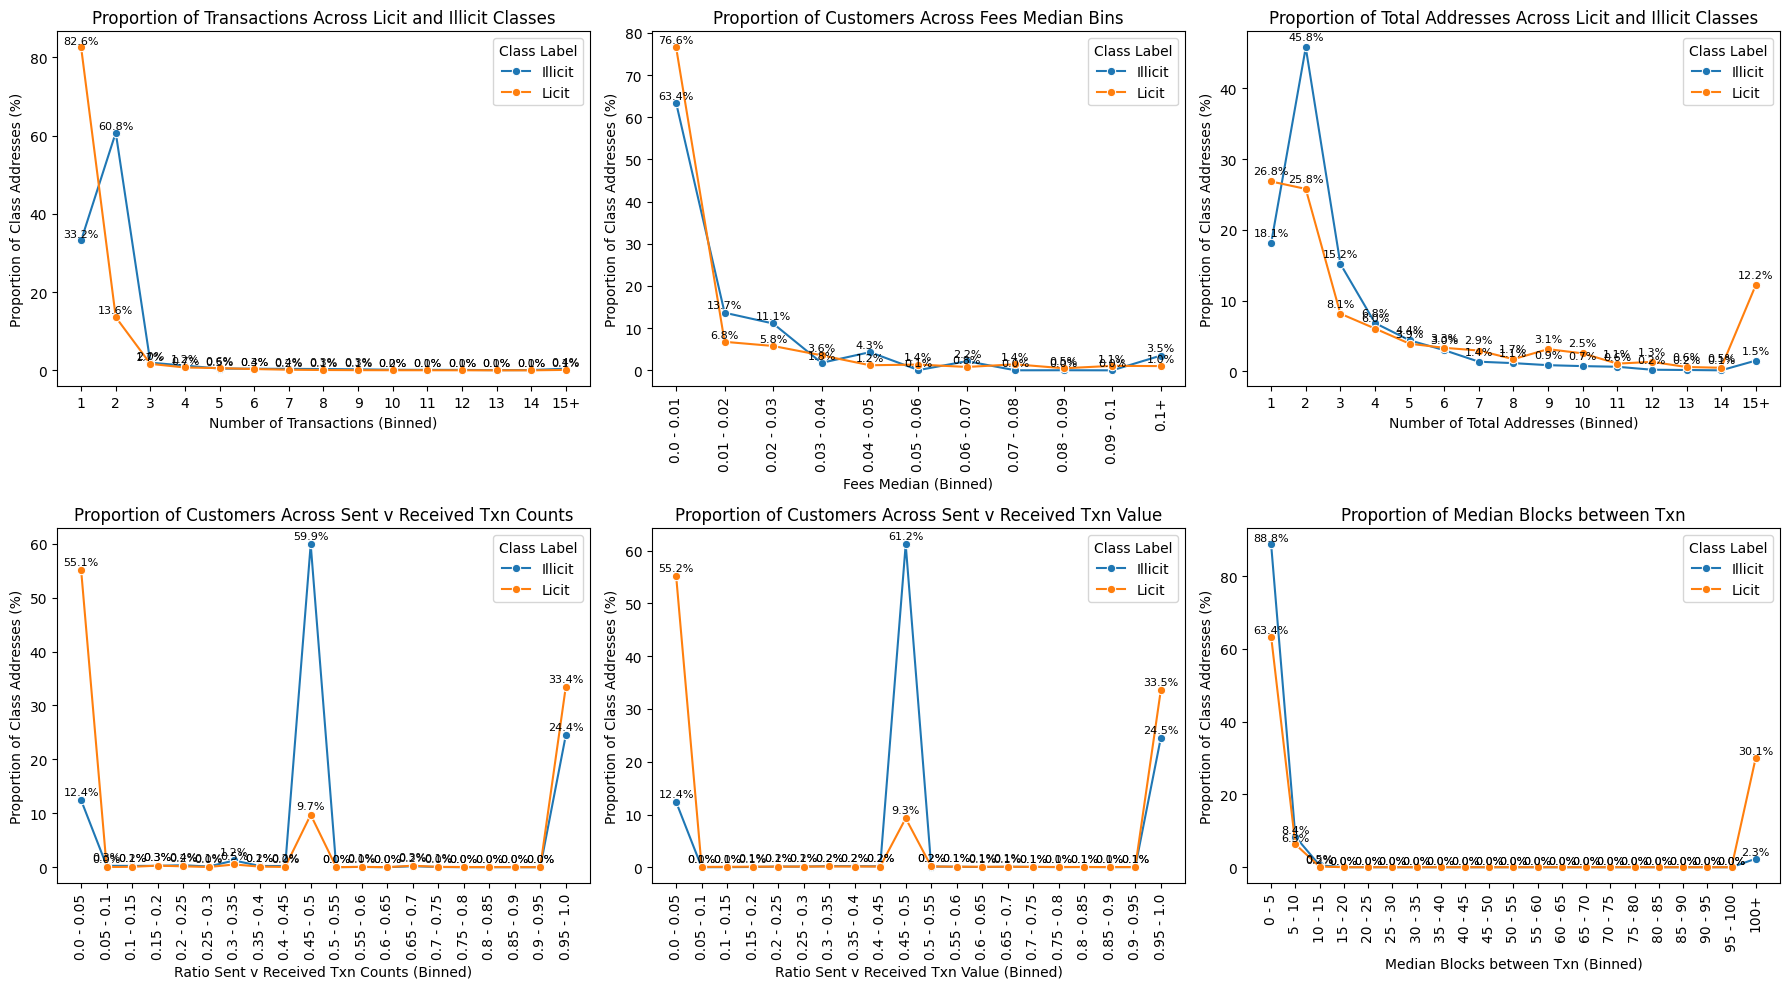

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with four subplots in a 2 (rows) x 3 (colums) grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=False)

# ----------------- Graph 1: % of Transactions by Class -----------------
distribution_data_1 = data.groupby(['total_txs_binned', 'class_label']).agg({'address': 'count'}).reset_index()
distribution_data_1.rename(columns={'address': 'Count of Addresses'}, inplace=True)
total_addresses_per_class_1 = distribution_data_1.groupby('class_label')['Count of Addresses'].transform('sum')
distribution_data_1['Percentage'] = (
    distribution_data_1['Count of Addresses'] / total_addresses_per_class_1 * 100
)
pivoted_data_1 = distribution_data_1.pivot(index='total_txs_binned', columns='class_label', values='Percentage').reset_index()
set_order = [str(i) for i in range(15)] + ['15+']
pivoted_data_1['total_txs_binned'] = pd.Categorical(pivoted_data_1['total_txs_binned'], categories=set_order, ordered=True)
pivoted_data_1.sort_values('total_txs_binned', inplace=True)
plot_data_1 = pivoted_data_1.melt(id_vars='total_txs_binned', var_name='Class Label', value_name='Percentage')

sns.lineplot(data=plot_data_1, x='total_txs_binned', y='Percentage', hue='Class Label', marker='o', sort=False, ax=axes[0, 0])
for line_data in plot_data_1.itertuples():
    axes[0, 0].text(line_data.total_txs_binned, line_data.Percentage + 1, f"{line_data.Percentage:.1f}%", horizontalalignment='center', fontsize=8, color='black')
axes[0, 0].set_title('Proportion of Transactions Across Licit and Illicit Classes')
axes[0, 0].set_xlabel('Number of Transactions (Binned)')
axes[0, 0].set_ylabel('Proportion of Class Addresses (%)')
axes[0, 0].legend(title='Class Label', loc='upper right')

# ----------------- Graph 2: Median Fees Paid -----------------
distribution_data_2 = data.groupby(['fees_median_binned', 'class_label']).agg({'address': 'count'}).reset_index()
distribution_data_2.rename(columns={'address': 'Count of Addresses'}, inplace=True)
total_addresses_per_class_2 = distribution_data_2.groupby('class_label')['Count of Addresses'].transform('sum')
distribution_data_2['Percentage'] = (
    distribution_data_2['Count of Addresses'] / total_addresses_per_class_2 * 100
)
sns.lineplot(data=distribution_data_2, x='fees_median_binned', y='Percentage', hue='class_label', marker='o', sort=False, ax=axes[0, 1])
for line_data in distribution_data_2.itertuples():
    axes[0, 1].text(getattr(line_data, 'fees_median_binned'), getattr(line_data, 'Percentage') + 1, f"{getattr(line_data, 'Percentage'):.1f}%", horizontalalignment='center', fontsize=8, color='black')
axes[0, 1].set_title('Proportion of Customers Across Fees Median Bins')
axes[0, 1].set_xlabel('Fees Median (Binned)')
axes[0, 1].set_ylabel('Proportion of Class Addresses (%)')
axes[0, 1].legend(title='Class Label', loc='upper right')
axes[0, 1].tick_params(axis='x', rotation=90)

# ----------------- Graph 3: Ratio of Txn Count Send v Received -----------------
distribution_data_3 = data.groupby(['prop_sent_total_txn_counts_binned', 'class_label']).agg({'address': 'count'}).reset_index()
distribution_data_3.rename(columns={'address': 'Count of Addresses'}, inplace=True)
total_addresses_per_class_3 = distribution_data_3.groupby('class_label')['Count of Addresses'].transform('sum')
distribution_data_3['Percentage'] = (
    distribution_data_3['Count of Addresses'] / total_addresses_per_class_3 * 100
)
sns.lineplot(data=distribution_data_3, x='prop_sent_total_txn_counts_binned', y='Percentage', hue='class_label', marker='o', sort=False, ax=axes[1, 0])
for line_data in distribution_data_3.itertuples():
    axes[1, 0].text(getattr(line_data, 'prop_sent_total_txn_counts_binned'), getattr(line_data, 'Percentage') + 1, f"{getattr(line_data, 'Percentage'):.1f}%", horizontalalignment='center', fontsize=8, color='black')
axes[1, 0].set_title('Proportion of Customers Across Sent v Received Txn Counts')
axes[1, 0].set_xlabel('Ratio Sent v Received Txn Counts (Binned)')
axes[1, 0].set_ylabel('Proportion of Class Addresses (%)')
axes[1, 0].legend(title='Class Label', loc='upper right')
axes[1, 0].tick_params(axis='x', rotation=90)

# ----------------- Graph 4: Ratio of Txn Value Sent v Received -----------------
distribution_data_4 = data.groupby(['prop_sent_total_txn_value_binned', 'class_label']).agg({'address': 'count'}).reset_index()
distribution_data_4.rename(columns={'address': 'Count of Addresses'}, inplace=True)
total_addresses_per_class_4 = distribution_data_4.groupby('class_label')['Count of Addresses'].transform('sum')
distribution_data_4['Percentage'] = (
    distribution_data_4['Count of Addresses'] / total_addresses_per_class_4 * 100
)
sns.lineplot(data=distribution_data_4, x='prop_sent_total_txn_value_binned', y='Percentage', hue='class_label', marker='o', sort=False, ax=axes[1, 1])
for line_data in distribution_data_4.itertuples():
    axes[1, 1].text(getattr(line_data, 'prop_sent_total_txn_value_binned'), getattr(line_data, 'Percentage') + 1, f"{getattr(line_data, 'Percentage'):.1f}%", horizontalalignment='center', fontsize=8, color='black')
axes[1, 1].set_title('Proportion of Customers Across Sent v Received Txn Value')
axes[1, 1].set_xlabel('Ratio Sent v Received Txn Value (Binned)')
axes[1, 1].set_ylabel('Proportion of Class Addresses (%)')
axes[1, 1].legend(title='Class Label', loc='upper right')
axes[1, 1].tick_params(axis='x', rotation=90)

# ----------------- Graph 5: Transacted with Address by Class -----------------

distribution_data_5 = data.groupby(['transacted_w_address_binned', 'class_label']).agg({'address': 'count'}).reset_index()
distribution_data_5.rename(columns={'address': 'Count of Addresses'}, inplace=True)
total_addresses_per_class_5 = distribution_data_5.groupby('class_label')['Count of Addresses'].transform('sum')
distribution_data_5['Percentage'] = (
    distribution_data_5['Count of Addresses'] / total_addresses_per_class_1 * 100
)
pivoted_data_5 = distribution_data_5.pivot(index='transacted_w_address_binned', columns='class_label', values='Percentage').reset_index()
set_order = [str(i) for i in range(15)] + ['15+']
pivoted_data_5['transacted_w_address_binned'] = pd.Categorical(pivoted_data_5['transacted_w_address_binned'], categories=set_order, ordered=True)
pivoted_data_5.sort_values('transacted_w_address_binned', inplace=True)
plot_data_5 = pivoted_data_5.melt(id_vars='transacted_w_address_binned', var_name='Class Label', value_name='Percentage')

sns.lineplot(data=plot_data_5, x='transacted_w_address_binned', y='Percentage', hue='Class Label', marker='o', sort=False, ax=axes[0, 2])
for line_data in plot_data_5.itertuples():
    axes[0, 2].text(line_data.transacted_w_address_binned, line_data.Percentage + 1, f"{line_data.Percentage:.1f}%", horizontalalignment='center', fontsize=8, color='black')
axes[0, 2].set_title('Proportion of Total Addresses Across Licit and Illicit Classes')
axes[0, 2].set_xlabel('Number of Total Addresses (Binned)')
axes[0, 2].set_ylabel('Proportion of Class Addresses (%)')
axes[0, 2].legend(title='Class Label', loc='upper right')

# ----------------- Graph 6: Blocks between Txn by Class -----------------

# Filter out rows where 'blocks_btwn_txs_median_binned' is "Not Binned"
filtered_data_6 = data[data['blocks_btwn_txs_median_binned'] != "Not Binned"]

# Group and aggregate data
distribution_data_6 = filtered_data_6.groupby(['blocks_btwn_txs_median_binned', 'class_label']).agg({'address': 'count'}).reset_index()
distribution_data_6.rename(columns={'address': 'Count of Addresses'}, inplace=True)

# Calculate total addresses per class for percentage calculation
total_addresses_per_class_6 = distribution_data_6.groupby('class_label')['Count of Addresses'].transform('sum')

# Add percentage column
distribution_data_6['Percentage'] = (
    distribution_data_6['Count of Addresses'] / total_addresses_per_class_6 * 100
)

# Ensure "Not Binned" is excluded from x-axis categories
valid_categories = [cat for cat in filtered_data_6['blocks_btwn_txs_median_binned'].cat.categories if cat != "Not Binned"]
distribution_data_6['blocks_btwn_txs_median_binned'] = pd.Categorical(
    distribution_data_6['blocks_btwn_txs_median_binned'],
    categories=valid_categories,
    ordered=True
)

# Plot data
sns.lineplot(
    data=distribution_data_6,
    x='blocks_btwn_txs_median_binned',
    y='Percentage',
    hue='class_label',
    marker='o',
    sort=False,
    ax=axes[1, 2]
)

# Annotate data points
for line_data in distribution_data_6.itertuples():
    axes[1, 2].text(
        getattr(line_data, 'blocks_btwn_txs_median_binned'),
        getattr(line_data, 'Percentage') + 1,
        f"{getattr(line_data, 'Percentage'):.1f}%",
        horizontalalignment='center',
        fontsize=8,
        color='black'
    )

# Set plot title and labels
axes[1, 2].set_title('Proportion of Median Blocks between Txn')
axes[1, 2].set_xlabel('Median Blocks between Txn (Binned)')
axes[1, 2].set_ylabel('Proportion of Class Addresses (%)')
axes[1, 2].legend(title='Class Label', loc='upper right')
axes[1, 2].tick_params(axis='x', rotation=90)

# ----------------- Adjust Layout -----------------
plt.tight_layout()
plt.show()



End